In [2]:
# import sys
# sys.path.append(r'C:\Users\Mechano_2\PycharmProjects\pro')
# sys.path

In [21]:
import mecha.DIC as dic
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mecha.fracture as fracture
from scipy import io
import matplotlib.patches as patches

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

num = 4
# pick point
radius_gap = 1.5
gap_count = 12
start_gap = 0.45

path = r'E:\experiment data\aluminum\2021-03-30\AL IMAGE\CTS_UVon_HSC'
image = dic.load_file(path)
file_num  = list(image.keys())[num][2:]

uu = io.loadmat(path+'/DIC'+'/'+file_num+'/t_uu.mat')['uu']
vv = io.loadmat(path+'/DIC'+'/'+file_num+'/t_vv.mat')['vv']
uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )

exx = io.loadmat(path+'/DIC'+'/'+file_num+'/t_exx.mat')['exx']
eyy = io.loadmat(path+'/DIC'+'/'+file_num+'/t_eyy.mat')['eyy']
exy = io.loadmat(path+'/DIC'+'/'+file_num+'/t_exy.mat')['exy']
ee = fracture.effective_strain(exx, eyy, exy)
# np.savetxt(path+'/DIC'+'/'+file_num+'/ee.csv',ee)
exx_resize = cv2.resize(exx,(0,0),fx=2, fy=2 )
eyy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
exy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
ee_resize = cv2.resize(ee,(0,0),fx=2, fy=2 )
# cv2.flip(ee_resize,1,ee_resize)
# cv2.flip(uu_resize,1,uu_resize)
# cv2.flip(vv_resize,1,vv_resize)



# Material property
n_hardening=17
yield_strength=535.435
poisson_ratio=0
alpha=0.585
In=2.78
youngs_modulus=71.7*1000

# Img parameter

contour_level = 15
ratio = 2/60
left, right, up_down =50,150,100


save_path =r'E:\experiment data\aluminum\2021-03-30\AL IMAGE\CTS_UVon_HSC/Output'
image = dic.load_file(path)
strain_data = np.array(pd.read_csv(path+'/effective_strain_ml.csv', encoding='CP949', delimiter=' ',header=None))
strain_hardening = np.array(pd.read_csv(path+'/HRR.csv', delim_whitespace=True))
eps_rr, eps_tt, eps_rt = strain_hardening[:,1], strain_hardening[:,2] ,strain_hardening[:,3]
strain_bar = np.sqrt(4* (np.power(eps_rr,2) + np.power(eps_tt,2) - eps_rr*eps_tt + 3 * np.power(eps_rt,2)) /9)
strain_hardening = np.hstack((strain_hardening[:,0].reshape(-1,1),strain_bar.reshape(-1,1)))


crack_tip = [[400,207],[397,210],[389,205],[387,202],[386,200]] # y, x

dst = ee_resize[crack_tip[num][0]-up_down:crack_tip[num][0]+up_down,crack_tip[num][1]-left:crack_tip[num][1]+right]

dst = dst.astype(float)
dst = np.where(dst>10, dst*0, dst)
gas = dst



max_crack_tip = [left, up_down]

# max_crack_tip = [np.argmax(gas)%(left+right), np.argmax(gas)//(left+right)]#x,y


count = 0
radius_g = 0
location = []
for _ in range(1, gap_count):
    if count == 0:
        location = dic.circle_location(start_gap/ratio, ratio,90,0)
        radius_g += radius_gap
        count += 1
    else:
        location = np.vstack((location, dic.circle_location(start_gap/ratio+radius_g, ratio,90,0)))
        radius_g += radius_gap

df = pd.DataFrame(location, columns=['x', 'y', 'angle', 'r'])
df.x = df.x + max_crack_tip[0]
df.y = df.y + max_crack_tip[1]
df.r = df.r*0.001



hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,1])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,1])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_strain=[]
theta_list = []



for y,x,theta in np.array(df[['y','x','angle']]):
    effective_strain = gas[np.round(y).astype(int),np.round(x).astype(int)]
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])


df['effective_strain'] = effective_strain
df['hardening_strain_bar'] = theta_list


plastic_k = np.power(df.effective_strain * youngs_modulus
                     / (df.hardening_strain_bar * alpha * yield_strength *
                        np.power(df.r, (-1 * n_hardening/(n_hardening+1)))), 1/n_hardening)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus


elastic_k1 = np.sqrt((j_integral * youngs_modulus))


fig, ax = plt.subplots(figsize=(10, 10))


ax.add_patch(
     patches.Rectangle(
        (155, 184),
        30,
        2,
        edgecolor = 'black',
        facecolor = 'black',
        fill=True
     ) )



ax.imshow(gas, cmap='gray')
# plt.axis('off')
csf = ax.contourf(gas, contour_level, cmap = 'jet')
CS = ax.contour(gas, contour_level, colors='black', linewidths = 0.5)

cbar= plt.colorbar(csf)
cbar.ax.tick_params(labelsize=18)


plt.scatter(max_crack_tip[0],max_crack_tip[1], color='blue', s=15,zorder=10)
plt.scatter(50,100, color='purple', s=15,zorder=11)
ax.text( 158,193, '1mm', fontsize=20, fontweight='bold')
ax.axis('off')
plt.savefig(r'E:\사진/dic%d.png'%num,dpi=300,bbox_inches='tight')
plt.scatter(df['x'],df['y'],color='black',s=5)
plt.savefig(r'E:\사진/dic_scatter%d.png'%num,dpi=300,bbox_inches='tight')
print('j_integral(kj/m^2):', 1000*j_integral)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

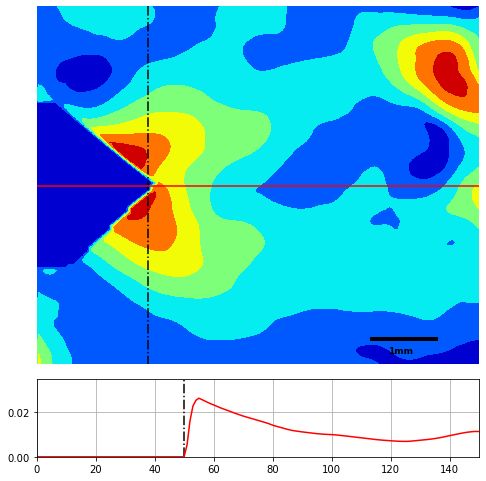

Save Done


In [6]:
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import pickle

ee_resize = dst
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=6, ncols=5)
# First axes
ax0 = fig.add_subplot(gs[0:4, 0:4])
# ax0.imshow(ee_resize,cmap='gray')
plt.gca().invert_yaxis()
plt.contourf(ee_resize, cmap= 'jet')
ax0.text( 158,193, '1mm', fontsize=9, fontweight='bold')
ax0.vlines(50,0,np.shape(ee_resize)[0]-1, color='black', linestyles='-.')
ax0.hlines(100,0,np.shape(ee_resize)[1]-1, color='red')
ax0.add_patch(
     patches.Rectangle(
        (150, 184),
        30,
        2,
        edgecolor = 'black',
        facecolor = 'black',
        fill=True
     ) )
ax0.axis('off')
# v axes
# ax1 = fig.add_subplot(gs[0:4, 4])
# ax1.plot(value[:,x_point],np.arange(len(value[:,x_point])),color='red')
# ax1.yaxis.set_label_position("right")
# ax1.yaxis.tick_right()
# plt.gca().invert_yaxis()
# u axes
ax2 = fig.add_subplot(gs[4, 0:4])
ax2.plot(ee_resize[100,:], color='red')
# ax2.plot(savgol_filter(value[:,y_point],31,2), color='green')
ax2.set_ylim(0,0.035)
ax2.set_xlim(0,150)
ax2.vlines(50,0,0.035, color='black', linestyles='-.')
plt.grid()
plt.savefig(save_path+'/%sdicㅇㅇㅇ.png'%num, dpi=300)
# plt.close()
plt.show()
plt.close()
with open('./dic.pkl','wb') as f:
    pickle.dump(ee_resize, f)
print('Save Done')


In [7]:

import numpy as np
np.average([8.14e4, 7.977e4,7.59e4,6.83e4])
np.average([5.22e4, 5.31e4,4.787e4,4.212e4])
np.average([2.035e4, 2.43e4,1.6386e4,1.19e4])
np.average([1.995e3, 979,1.78e3,689])

(1-poisson_ratio**2)/youngs_modulus * 56**2

0.04373779637377964